In [247]:
import sqlite3
import csv
import pandas as pd
from datetime import datetime

In [295]:
from __future__ import absolute_import, division, print_function, unicode_literals
%env KMP_DUPLICATE_LIB_OK=TRUE

import pathlib

import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

env: KMP_DUPLICATE_LIB_OK=TRUE


In [249]:
def read_sales_csv(filename):
    sales = []
    with open(filename) as csvfile:
        reader = csv.DictReader(csvfile)
        for row in reader:
            date = datetime.strptime(row['date'], '%m/%d/%y')
            sales.append({'date': date,
                     'days_ago': (datetime.now() - date).days,
                     'account_number': row['account_number'],
                     'price': int(row['price'])})
    return sales

conn = sqlite3.connect('NW_Central_OKC_w_land_area.db')
c = conn.cursor()

sales = read_sales_csv('sales_list_2019.csv')
sales = sales + read_sales_csv('sales_list_2018.csv')
sales = sales + read_sales_csv('sales_list_2017.csv')

In [250]:
# probably not the best way to do this, very slow
'''
for s in sales:
    t = (s['account_number'],)
    c.execute("SELECT * FROM realproperty WHERE account_number = ?",t)
    print(c.fetchone())
    '''

'\nfor s in sales:\n    t = (s[\'account_number\'],)\n    c.execute("SELECT * FROM realproperty WHERE account_number = ?",t)\n    print(c.fetchone())\n    '

In [251]:
combined_df = pd.read_sql_query("SELECT * FROM realproperty INNER JOIN buildings ON realproperty.id = buildings.local_property_id;", conn)
rp_df = pd.read_sql_query("SELECT * FROM realproperty WHERE property_type = 'Residential'", conn)
sqft_sums = combined_df.groupby(['account_number'])['sq_ft'].sum()

property_df_sb = rp_df.set_index('account_number')
property_df_sb['sqft_sum'] = sqft_sums
display(property_df_sb)

,id,propertyid,property_type,location,building_name_occupant,city,owner_name_1,owner_name_2,billing_address_1,billing_address_2,...,land_size,lot_width,lot_depth,land_value,quarter_section_description,subdivision,block,lot,legal_description,sqft_sum
account_number,,,,,,,,,,,,,,,,,,,,,
R049810025,1,130116,Residential,400 NW 43RD ST,,OKLAHOMA CITY,YOUNGS STEVEN ROGERS,TURLEY ALLISON,400 NW 43RD ST,,...,13068.0,None,None,47449,Sect 16-T12N-R3W Qtr NE,EDGEMERE TERRACE,001,001,EDGEMERE TERRACE 001 001,1824.0
R049640005,4,131004,Residential,5021 N WALKER AVE,,OKLAHOMA CITY,VEITCH JAMIE PER REP,BRADSHAW TIMOTHY JOE ESTATE,5021 N WALKER AVE,,...,9147.6,None,None,34216,Sect 16-T12N-R3W Qtr NW,DOUGLAS PLACE ADD,001,000,DOUGLAS PLACE ADD 001 000 LOTS 1 & 2,1352.0
R049810050,7,130117,Residential,408 NW 43RD ST,,OKLAHOMA CITY,JUNGMAN TIMOTHY WILLIAM & JULIE LYN,,408 NW 43RD ST,,...,9147.6,None,None,41310,Sect 16-T12N-R3W Qtr NE,EDGEMERE TERRACE,001,002,EDGEMERE TERRACE 001 002,2677.0
R049640010,11,131005,Residential,504 NW 50TH ST,,OKLAHOMA CITY,DICKSON JERRY ROBERT,,504 NW 50TH ST,,...,6969.6,None,None,26320,Sect 16-T12N-R3W Qtr NW,DOUGLAS PLACE ADD,001,000,DOUGLAS PLACE ADD 001 000 LOTS 3 & 4,1386.0
R049810075,12,130118,Residential,412 NW 43RD ST,,OKLAHOMA CITY,STUCKY ANIKA C,,412 NW 43RD ST,,...,9147.6,None,None,41310,Sect 16-T12N-R3W Qtr NE,EDGEMERE TERRACE,001,003,EDGEMERE TERRACE 001 003,1957.0
R049480080,13,130504,Residential,1009 NW 42ND ST,,OKLAHOMA CITY,SPEARS KENNETH L & REGINA,,210 NW 10TH ST,,...,7405.2,None,None,59378,Sect 16-T12N-R3W Qtr SW,CROWN HEIGHTS ADD,001,004,CROWN HEIGHTS ADD 001 004,1961.0
R049640015,14,131006,Residential,508 NW 50TH ST,,OKLAHOMA CITY,GARRETT & COMPANY LLC,,9701 BROADWAY EXT,,...,6969.6,None,None,26320,Sect 16-T12N-R3W Qtr NW,DOUGLAS PLACE ADD,001,000,DOUGLAS PLACE ADD 001 000 LOTS 5 & 6,1092.0
R049810100,15,130119,Residential,418 NW 43RD ST,,OKLAHOMA CITY,BRADEN THOMAS GARY & BEVERLY JOAN,REVOCABLE LIVING TRUST,418 NW 43RD ST,,...,9147.6,None,None,41310,Sect 16-T12N-R3W Qtr NE,EDGEMERE TERRACE,001,004,EDGEMERE TERRACE 001 004,2047.0
R054850009,16,132187,Residential,1528 NW 41ST ST,,OKLAHOMA CITY,MCMURREY MICHELE L,,1528 NW 41ST ST,,...,7405.2,None,None,23606,Sect 17-T12N-R3W Qtr SE,PUTNAM HEIGHTS ADD,00A,000,PUTNAM HEIGHTS ADD 00A 000 LOTS 1 2 & 3,1396.0


In [252]:
# This filters for subdivision based on number of properties in that sub. Let's change it
# later to filter for number of transactions.
sublist = (property_df_sb[['subdivision']]
            .assign(count = 0)
            .groupby("subdivision")
            .count())
sublist = sublist.where(sublist['count'] >= 100).dropna()
sublist_names = sublist.index.values
#           where(property_df_sb.count(property_df_sb['subdivision']) > 20)
#           ['subdivision'].unique().dropna())
display(sublist_names)

'''
allowed_subs_list = [
    'EDGEMERE TERRACE',
    'DOUGLAS PLACE ADD',
    'CROWN HEIGHTS ADD'
]
'''
property_df_sb['subdivision'] = property_df_sb.apply(lambda x: 'NOT LISTED' if x['subdivision'] not in sublist_names else x['subdivision'], axis=1)
#display(property_df_sb)

array(['AURORA ADDITION', 'BAUMANS ADDITION', 'BELL VERN ADDITION',
       'CARLE & COLCORD ADDITION', 'CASHION PLACE ADDITION',
       'CASHION PLACE AMD', 'CENTRAL PARK ADDITION',
       'CLASSENS CREAM RIDGE', 'COLLEGE ADDITION', 'CRESTWOOD ADDITION',
       'CROWN HEIGHTS ADD', 'DARRALLS SECOND ADD', 'DENNISTON PARK ADD',
       'DOUGLAS PLACE ADD', 'EDGEMERE PARK ADD', 'EDGEMERE TERRACE',
       'EPWORTH VIEW ADD', 'GARDEN ADDITION', 'GATEWOOD ADDITION',
       'GRAND VIEW ADDITION', 'GUERNSEY PARK PLACE',
       'HEMINGWAY CONDOMINIUMS', 'INGLESIDE TO OKLA CITY',
       'JEFFERSON PARK ADD', 'LAS VEGAS ADDITION',
       'LINWOOD PLACE AMENDED', 'LINWOOD PLACE SECOND',
       'LYONS WILL ROGERS PK', 'MAYFAIR HEIGHTS BLKS 1 THRU 29',
       'MILAM PLACE ADDITION', 'MILITARY PARK ADD', 'MILLERS BOULEVARD',
       'MORRIS WILL ROGER PARK', 'NEAS ADDITION', 'PACKINGHOUSE PARK',
       'PARKER & COLCORD ADD', 'PUTNAM HEIGHTS 2ND', 'PUTNAM HEIGHTS ADD',
       'RAVENSWOOD ADDITION', 'RI

In [253]:
#sales_df = pd.read_csv('sales_list_2019.csv')
sales_df = pd.DataFrame(sales)
sales_df = sales_df[sales_df.price != 0]
display(sales_df)

,account_number,date,days_ago,price
0,R091477265,2019-08-16,57,25500
1,R149911385,2019-08-16,57,28500
2,R154061075,2019-08-15,58,150000
3,R146091230,2019-08-15,58,2010000
4,R116954795,2019-08-14,59,270000
5,R066544050,2019-08-13,60,20000
6,R172731010,2019-08-12,61,25000
8,R066307030,2019-08-10,63,20000
9,R145481200,2019-08-09,64,460000
10,R013200896,2019-08-09,64,530000


In [254]:
merged_df = pd.merge(property_df_sb, sales_df, on='account_number', how='inner')
display(merged_df)

,account_number,id,propertyid,property_type,location,building_name_occupant,city,owner_name_1,owner_name_2,billing_address_1,...,land_value,quarter_section_description,subdivision,block,lot,legal_description,sqft_sum,date,days_ago,price
0,R049640005,4,131004,Residential,5021 N WALKER AVE,,OKLAHOMA CITY,VEITCH JAMIE PER REP,BRADSHAW TIMOTHY JOE ESTATE,5021 N WALKER AVE,...,34216,Sect 16-T12N-R3W Qtr NW,DOUGLAS PLACE ADD,001,000,DOUGLAS PLACE ADD 001 000 LOTS 1 & 2,1352.0,2019-07-02,102,108000
1,R049640005,4,131004,Residential,5021 N WALKER AVE,,OKLAHOMA CITY,VEITCH JAMIE PER REP,BRADSHAW TIMOTHY JOE ESTATE,5021 N WALKER AVE,...,34216,Sect 16-T12N-R3W Qtr NW,DOUGLAS PLACE ADD,001,000,DOUGLAS PLACE ADD 001 000 LOTS 1 & 2,1352.0,2019-05-10,155,108000
2,R049810175,29,130122,Residential,436 NW 43RD ST,,OKLAHOMA CITY,BELFLOWER ADAM P & ALEXANDRA,,436 NW 43RD ST,...,41310,Sect 16-T12N-R3W Qtr NE,EDGEMERE TERRACE,001,007,EDGEMERE TERRACE 001 007,2018.0,2019-04-05,190,305000
3,R054850054,39,132192,Residential,1508 NW 41ST ST,,OKLAHOMA CITY,LETOURNEAU KATHRYN,MARTIN SCOTT,1508 NW 41ST ST,...,15950,Sect 17-T12N-R3W Qtr SE,PUTNAM HEIGHTS ADD,00A,000,PUTNAM HEIGHTS ADD 00A 000 LOTS 12 & 13,1626.0,2017-06-21,843,168500
4,R049810225,41,130124,Residential,448 NW 43RD ST,,OKLAHOMA CITY,ANDERSON MARK A & VICKIE R,,448 NW 43RD ST,...,41310,Sect 16-T12N-R3W Qtr NE,EDGEMERE TERRACE,001,009,EDGEMERE TERRACE 001 009,2834.0,2018-06-15,484,475000
5,R049640070,56,131015,Residential,5000 N LEE AVE,,OKLAHOMA CITY,JOHNSON MARK D & MOLLY JANE,,541 NW 47TH ST,...,26320,Sect 16-T12N-R3W Qtr NW,DOUGLAS PLACE ADD,001,000,DOUGLAS PLACE ADD 001 000 LOTS 23 & 24,1429.0,2019-05-15,150,157000
6,R054850099,59,132197,Residential,1509 NW 40TH ST,,OKLAHOMA CITY,COCHRAN DAVID,COCHRAN JASMINE,1509 NW 40TH ST,...,24500,Sect 17-T12N-R3W Qtr SE,PUTNAM HEIGHTS ADD,00A,000,PUTNAM HEIGHTS ADD 00A 000 LOTS 22 & 23,1718.0,2017-05-04,891,225000
7,R049820200,62,130383,Residential,305 NW 42ND ST,,OKLAHOMA CITY,CONIGLIONE ROBERT A,,305 NW 42ND ST,...,87113,Sect 16-T12N-R3W Qtr SE,NOT LISTED,001,002,EDGEMERE HEIGHTS ADD 001 002,2541.0,2019-05-29,136,415000
8,R049810425,75,130132,Residential,415 NW 43RD ST,,OKLAHOMA CITY,CODDOU STEPHEN,CODDOU SHARON,415 NW 43RD ST,...,38556,Sect 16-T12N-R3W Qtr NE,EDGEMERE TERRACE,002,007,EDGEMERE TERRACE 002 007,2097.0,2019-06-05,129,343500
9,R049810425,75,130132,Residential,415 NW 43RD ST,,OKLAHOMA CITY,CODDOU STEPHEN,CODDOU SHARON,415 NW 43RD ST,...,38556,Sect 16-T12N-R3W Qtr NE,EDGEMERE TERRACE,002,007,EDGEMERE TERRACE 002 007,2097.0,2019-05-06,159,343500


In [255]:
new_df = merged_df[['land_size', 'land_value', 'subdivision', 'sqft_sum', 'price', 'days_ago']]

display(new_df)

,land_size,land_value,subdivision,sqft_sum,price,days_ago
0,9147.6,34216,DOUGLAS PLACE ADD,1352.0,108000,102
1,9147.6,34216,DOUGLAS PLACE ADD,1352.0,108000,155
2,9147.6,41310,EDGEMERE TERRACE,2018.0,305000,190
3,4791.6,15950,PUTNAM HEIGHTS ADD,1626.0,168500,843
4,9147.6,41310,EDGEMERE TERRACE,2834.0,475000,484
5,6969.6,26320,DOUGLAS PLACE ADD,1429.0,157000,150
6,6969.6,24500,PUTNAM HEIGHTS ADD,1718.0,225000,891
7,17859.6,87113,NOT LISTED,2541.0,415000,136
8,8276.4,38556,EDGEMERE TERRACE,2097.0,343500,129
9,8276.4,38556,EDGEMERE TERRACE,2097.0,343500,159


In [256]:
from sklearn.model_selection import train_test_split
from sklearn import preprocessing

In [257]:
le = preprocessing.LabelEncoder()
new_df['sub_encoded'] = le.fit_transform(new_df['subdivision'])
#print(X)
new_df = new_df.drop(columns=['subdivision']).dropna()
display(new_df)

X = new_df[['land_size', 'land_value', 'sub_encoded', 'sqft_sum', 'days_ago']]
y = new_df['price']

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)

/Users/scoot/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


,land_size,land_value,sqft_sum,price,days_ago,sub_encoded
0,9147.6,34216,1352.0,108000,102,13
1,9147.6,34216,1352.0,108000,155,13
2,9147.6,41310,2018.0,305000,190,15
3,4791.6,15950,1626.0,168500,843,38
4,9147.6,41310,2834.0,475000,484,15
5,6969.6,26320,1429.0,157000,150,13
6,6969.6,24500,1718.0,225000,891,38
7,17859.6,87113,2541.0,415000,136,34
8,8276.4,38556,2097.0,343500,129,15
9,8276.4,38556,2097.0,343500,159,15


In [258]:
from sklearn.neighbors import KNeighborsRegressor
knn = KNeighborsRegressor(n_neighbors=5)

In [259]:
knn.fit(X_train, y_train)

KNeighborsRegressor(algorithm='auto', leaf_size=30, metric='minkowski',
                    metric_params=None, n_jobs=None, n_neighbors=5, p=2,
                    weights='uniform')

In [260]:
knn.score(X_test, y_test)

0.5226809776223452

In [261]:
test = knn.predict([[10000, 80000, 50, 3000, 10]])

In [262]:
test[0]

538600.0

# Linear Regression

Now let's try this with linear regression rather than KNN.

In [263]:
from sklearn.linear_model import LinearRegression
print(X_train)

linreg = LinearRegression().fit(X_train, y_train)

      land_size  land_value  sub_encoded  sqft_sum  days_ago
2450     7405.2       22650            0    1399.0       186
3394     6969.6       56490           51    1567.0       684
1473     6098.4       14040           44    1095.0       904
2030     6534.0       14271           34    1244.0       110
1841     6534.0       14190           39    1040.0       634
1591     7405.2       17400           34    1390.0       743
1284     7840.8       19734           28    1035.0       235
3219     6969.6       23170           34    1324.0       444
3324     6969.6        7425           53     800.0       182
3782     9147.6       48500           18       0.0       872
2246     7405.2       35250           25    1634.0       541
3018    11325.6       37575           31    2409.0        88
2651     6969.6       34790           51    1270.0       428
1714     6969.6       14910           55    1476.0       883
1674     6969.6       36153           34    1176.0       963
1498     6534.0       15

In [264]:
linreg.predict([[10000,80000,1,5000,10]])

array([608264.69398952])

In [265]:
linreg.score(X_test, y_test)

0.5444111932515892

# One Hot Encoding

Let's change the subdivision feature to one hot encoding

In [266]:
new_df = (merged_df[['land_size', 'land_value', 'subdivision', 'sqft_sum', 'days_ago', 'price']][merged_df.price != 0]
          .dropna()
          .reset_index()
          .drop(columns=['index']))
#new_df = new_df[new_df.price != 0]

ohenc = preprocessing.OneHotEncoder()
ohenc.fit([[x] for x in new_df['subdivision']])
ohenc.categories_
encoded = ohenc.transform([[x] for x in new_df['subdivision']]).toarray()
encoded_df = pd.DataFrame(encoded, columns=["Subdivision_"+str(i) for i in range(encoded.shape[1])])
#display(encoded_df)
#new_df = pd.get_dummies(new_df, prefix=['subdivision'])

new_df = new_df.drop(columns=['subdivision'])
new_df = pd.concat([new_df, encoded_df], axis=1)
display(new_df)

,land_size,land_value,sqft_sum,days_ago,price,Subdivision_0,Subdivision_1,Subdivision_2,Subdivision_3,Subdivision_4,...,Subdivision_49,Subdivision_50,Subdivision_51,Subdivision_52,Subdivision_53,Subdivision_54,Subdivision_55,Subdivision_56,Subdivision_57,Subdivision_58
0,9147.6,34216,1352.0,102,108000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,9147.6,34216,1352.0,155,108000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,9147.6,41310,2018.0,190,305000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,4791.6,15950,1626.0,843,168500,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,9147.6,41310,2834.0,484,475000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,6969.6,26320,1429.0,150,157000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6,6969.6,24500,1718.0,891,225000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7,17859.6,87113,2541.0,136,415000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8,8276.4,38556,2097.0,129,343500,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9,8276.4,38556,2097.0,159,343500,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [267]:
X = new_df.drop('price',axis=1)
y = new_df['price']
#display(y)
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)
linreg = LinearRegression().fit(X_train, y_train)
#display(X_test)
linreg.score(X_test, y_test)

0.5786333364300207

In [268]:
import numpy as np
ch_oh = ohenc.transform([["EDGEMERE TERRACE"]]).toarray()
ch_args = [10000, 40000, 3000, 10] + ch_oh.tolist()[0]
ch_args = [6400, 34790, 1500, 10] + ch_oh.tolist()[0]
#ch_args = ch_oh.tolist()
linreg.predict([ch_args])

array([212637.9197998])

In [269]:
[1,2,3] + [4,5,6]

[1, 2, 3, 4, 5, 6]

# Tensorflow

Now let's try building a model with Tensorflow

In [270]:
# we'll use new_df

new_df

,land_size,land_value,sqft_sum,days_ago,price,Subdivision_0,Subdivision_1,Subdivision_2,Subdivision_3,Subdivision_4,...,Subdivision_49,Subdivision_50,Subdivision_51,Subdivision_52,Subdivision_53,Subdivision_54,Subdivision_55,Subdivision_56,Subdivision_57,Subdivision_58
0,9147.6,34216,1352.0,102,108000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,9147.6,34216,1352.0,155,108000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,9147.6,41310,2018.0,190,305000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,4791.6,15950,1626.0,843,168500,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,9147.6,41310,2834.0,484,475000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,6969.6,26320,1429.0,150,157000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6,6969.6,24500,1718.0,891,225000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7,17859.6,87113,2541.0,136,415000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8,8276.4,38556,2097.0,129,343500,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9,8276.4,38556,2097.0,159,343500,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [271]:
X = new_df.drop('price',axis=1)
y = new_df['price']
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)

In [272]:
train_stats = X_train.describe()
train_stats = train_stats.transpose()
train_stats

,count,mean,std,min,25%,50%,75%,max
land_size,2867.0,7627.652878,3090.308201,0.0,6969.6,6969.6,7840.8,51836.4
land_value,2867.0,31220.738054,27812.854940,917.0,17910.5,25050.0,35001.5,603866.0
sqft_sum,2867.0,1512.934077,825.975911,0.0,1080.0,1382.0,1804.0,20021.0
days_ago,2867.0,535.916986,273.315941,63.0,299.0,529.0,781.0,1014.0
Subdivision_0,2867.0,0.018486,0.134725,0.0,0.0,0.0,0.0,1.0
Subdivision_1,2867.0,0.009418,0.096603,0.0,0.0,0.0,0.0,1.0
Subdivision_2,2867.0,0.004534,0.067197,0.0,0.0,0.0,0.0,1.0
Subdivision_3,2867.0,0.002790,0.052759,0.0,0.0,0.0,0.0,1.0
Subdivision_4,2867.0,0.005930,0.076788,0.0,0.0,0.0,0.0,1.0
Subdivision_5,2867.0,0.012905,0.112887,0.0,0.0,0.0,0.0,1.0


In [273]:
def norm(x):
    return (x-train_stats['mean']) / train_stats['std']

normed_train_data = norm(X_train).dropna(axis=1)
normed_test_data = norm(X_test)

normed_train_data.dropna(axis=1).describe()

,land_size,land_value,sqft_sum,days_ago,Subdivision_0,Subdivision_1,Subdivision_2,Subdivision_3,Subdivision_4,Subdivision_5,...,Subdivision_49,Subdivision_50,Subdivision_51,Subdivision_52,Subdivision_53,Subdivision_54,Subdivision_55,Subdivision_56,Subdivision_57,Subdivision_58
count,2.867000e+03,2.867000e+03,2.867000e+03,2.867000e+03,2.867000e+03,2.867000e+03,2.867000e+03,2.867000e+03,2.867000e+03,2.867000e+03,...,2.867000e+03,2.867000e+03,2.867000e+03,2.867000e+03,2.867000e+03,2.867000e+03,2.867000e+03,2.867000e+03,2.867000e+03,2.867000e+03
mean,6.751256e-15,-1.927981e-17,9.913397e-18,-8.050763e-17,-1.913363e-16,1.026976e-15,7.956276e-16,6.750017e-16,1.942406e-16,2.533822e-16,...,-7.160106e-17,-6.960192e-16,3.974072e-16,-2.336958e-16,-2.742739e-16,9.347540e-16,5.743574e-16,7.674073e-16,-1.356315e-16,4.232362e-16
std,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,...,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00
min,-2.468250e+00,-1.089559e+00,-1.831693e+00,-1.730294e+00,-1.372145e-01,-9.748706e-02,-6.747905e-02,-5.288861e-02,-7.721937e-02,-1.143225e-01,...,-7.003859e-02,-8.991318e-02,-2.205214e-01,-5.288861e-02,-1.062240e-01,-1.045327e-01,-1.423995e-01,-9.377395e-02,-1.111506e-01,-1.672042e-01
25%,-2.129409e-01,-4.785642e-01,-5.241486e-01,-8.668246e-01,-1.372145e-01,-9.748706e-02,-6.747905e-02,-5.288861e-02,-7.721937e-02,-1.143225e-01,...,-7.003859e-02,-8.991318e-02,-2.205214e-01,-5.288861e-02,-1.062240e-01,-1.045327e-01,-1.423995e-01,-9.377395e-02,-1.111506e-01,-1.672042e-01
50%,-2.129409e-01,-2.218664e-01,-1.585205e-01,-2.530766e-02,-1.372145e-01,-9.748706e-02,-6.747905e-02,-5.288861e-02,-7.721937e-02,-1.143225e-01,...,-7.003859e-02,-8.991318e-02,-2.205214e-01,-5.288861e-02,-1.062240e-01,-1.045327e-01,-1.423995e-01,-9.377395e-02,-1.111506e-01,-1.672042e-01
75%,6.897277e-02,1.359358e-01,3.523903e-01,8.967022e-01,-1.372145e-01,-9.748706e-02,-6.747905e-02,-5.288861e-02,-7.721937e-02,-1.143225e-01,...,-7.003859e-02,-8.991318e-02,-2.205214e-01,-5.288861e-02,-1.062240e-01,-1.045327e-01,-1.423995e-01,-9.377395e-02,-1.111506e-01,-1.672042e-01
max,1.430561e+01,2.058923e+01,2.240751e+01,1.749195e+00,7.285315e+00,1.025419e+01,1.481425e+01,1.890107e+01,1.294560e+01,8.744130e+00,...,1.427286e+01,1.111796e+01,4.533125e+00,1.890107e+01,9.410784e+00,9.563052e+00,7.020046e+00,1.066022e+01,8.993668e+00,5.978623e+00


In [274]:
def build_model():
    model = keras.Sequential([
        layers.Dense(64, activation=tf.nn.relu, input_shape=[len(normed_train_data.keys())]),
        layers.Dense(64, activation=tf.nn.relu),
        layers.Dense(1)]
    )
    
    optimizer = tf.keras.optimizers.RMSprop(0.001)
    
    model.compile(loss="mean_squared_error",
                 optimizer=optimizer,
                  metrics=['mean_absolute_error', 'mean_squared_error'])
    return model

model = build_model()

In [275]:
model.summary()
print(len(X_train))

Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_27 (Dense)             (None, 64)                4096      
_________________________________________________________________
dense_28 (Dense)             (None, 64)                4160      
_________________________________________________________________
dense_29 (Dense)             (None, 1)                 65        
Total params: 8,321
Trainable params: 8,321
Non-trainable params: 0
_________________________________________________________________
2867


In [276]:
example_result = model.predict(normed_train_data[:10])
print(normed_train_data[:10])
example_result

      land_size  land_value  sqft_sum  days_ago  Subdivision_0  Subdivision_1  \
2439  -0.071984   -0.308157 -0.137939 -1.280266       7.285315      -0.097487   
3365  -0.212941    0.908546  0.065457  0.541802      -0.137215      -0.097487   
1462  -0.494854   -0.617727 -0.505988  1.346731      -0.137215      -0.097487   
2019  -0.353898   -0.609421 -0.325596 -1.558332      -0.137215      -0.097487   
1830  -0.353898   -0.612333 -0.572576  0.358863      -0.137215      -0.097487   
1580  -0.071984   -0.496919 -0.148835  0.757669      -0.137215      -0.097487   
1273   0.068973   -0.413001 -0.578630 -1.100986      -0.137215      -0.097487   
3190  -0.212941   -0.289461 -0.228740 -0.336303      -0.137215      -0.097487   
3295  -0.212941   -0.855566 -0.863141 -1.294901      -0.137215      -0.097487   
3752   0.491843    0.621269 -1.831693  1.229650      -0.137215      -0.097487   

      Subdivision_2  Subdivision_3  Subdivision_4  Subdivision_5  ...  \
2439      -0.067479      -0.052889 

array([[0.90351874],
       [0.08130363],
       [1.444466  ],
       [0.6317388 ],
       [1.6335036 ],
       [0.36330318],
       [2.1173813 ],
       [0.43003088],
       [1.4546416 ],
       [1.567895  ]], dtype=float32)

In [277]:
history = model.fit(normed_train_data, y_train, epochs=1000, validation_split=0.2, verbose=0)

In [278]:
hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch
hist

,loss,mean_absolute_error,mean_squared_error,val_loss,val_mean_absolute_error,val_mean_squared_error,epoch
0,5.905297e+10,180640.203125,5.905297e+10,5.582065e+10,179920.062500,5.582066e+10,0
1,5.903122e+10,180590.562500,5.903123e+10,5.579070e+10,179850.187500,5.579069e+10,1
2,5.898832e+10,180493.312500,5.898832e+10,5.573667e+10,179727.421875,5.573667e+10,2
3,5.890779e+10,180327.359375,5.890779e+10,5.564645e+10,179528.031250,5.564645e+10,3
4,5.879700e+10,180085.921875,5.879700e+10,5.552609e+10,179260.437500,5.552609e+10,4
5,5.864431e+10,179755.562500,5.864431e+10,5.535539e+10,178885.906250,5.535539e+10,5
6,5.842084e+10,179303.203125,5.842083e+10,5.513496e+10,178405.093750,5.513495e+10,6
7,5.815899e+10,178743.125000,5.815899e+10,5.485191e+10,177789.359375,5.485191e+10,7
8,5.780922e+10,178019.156250,5.780922e+10,5.450426e+10,177032.031250,5.450426e+10,8
9,5.739573e+10,177160.609375,5.739574e+10,5.408395e+10,176116.062500,5.408395e+10,9


In [279]:
# 51943.89
# 50982.98 after doubling first param
# 36271.77 after doubling # of epochs to 5000
# 17741.39 after doubling again to 10000 epochs

(50000, 60000)

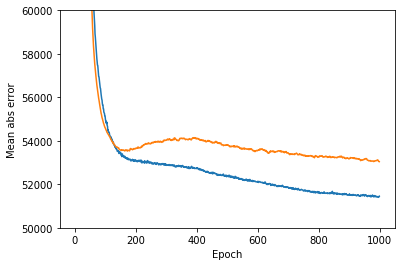

In [292]:
plt.figure()
plt.xlabel("Epoch")
plt.ylabel("Mean abs error")
plt.plot(hist['epoch'], hist['mean_absolute_error'],
        label='Train Error')
plt.plot(hist['epoch'], hist['val_mean_absolute_error'],
        label='Val Error')
plt.ylim(50000,60000)

(8000000000, 10000000000)

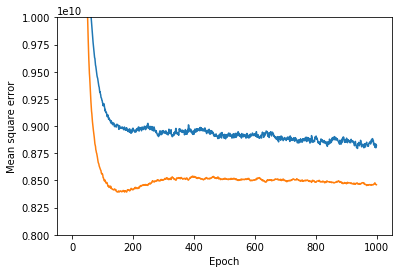

In [290]:
plt.figure()
plt.xlabel("Epoch")
plt.ylabel("Mean square error")
plt.plot(hist['epoch'], hist['mean_squared_error'],
        label='Train Error')
plt.plot(hist['epoch'], hist['val_mean_squared_error'],
        label='Val Error')
plt.ylim(8000000000,10000000000)

In [293]:
# remove the columns we removed from test data
normed_test_data_new = normed_test_data[list(normed_train_data.columns.values)] 

test_predictions = model.predict(normed_test_data_new).flatten()

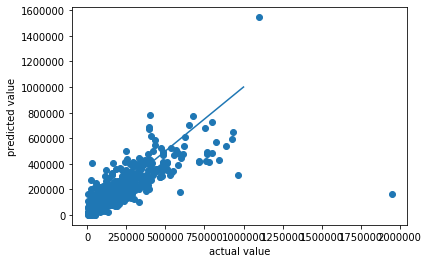

In [294]:
plt.scatter(y_test, test_predictions)
plt.xlabel("actual value")
plt.ylabel("predicted value")
_ = plt.plot([-100,1000000],[-100,1000000])